Authors : Asaf Zaks 302329693, Peleg Biton 203842703 & Omer Nagar 307937714

In [12]:
import pandas as pd
import numpy as np
import math 
import matplotlib.pyplot as plt
import seaborn as sns
import timeit
import time
from tqdm import tqdm
import xgboost as xgb
import gc; gc.enable()
import gensim 
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import *
from tensorflow.keras.metrics import MeanSquaredError, RootMeanSquaredError, MeanAbsoluteError
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import precision_score,recall_score, f1_score, confusion_matrix,roc_auc_score,roc_curve, accuracy_score,mean_squared_error, mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from keras.utils import plot_model
from sklearn import preprocessing
from keras import backend

 
sns.set()

save_dir = 'saved_models/'
path = '/content/drive/MyDrive/Ass3/home-depot-product-search-relevance/'
results_df= pd.DataFrame(columns=['Model Name','Runtime','Train RMSE','Val RMSE','Test RMSE','Train MAE','Val MAE','Test MAE'])

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In this work we will get data from a Home deput search engine, that contains a search query - few words, and a product description - few sentences, for the product that is relevant to the query.

Out train set as also a relevace score to measure how relevant the product description to the search query, we will use supervised learning to create weight that will allow us to make prediction on the relevance of the test set, and compare it to the offical contest results that were published on kaggle.

# Character level LSTM


In charge - Asaf Zaks


## Part 1
We will first get to know the data.
We have a dataset containing:
product id -- product title -- the search term -- product relevance

And we have a second dataset containing:
product id -- product description

both datasets presented below:

In [97]:
all_train_data = pd.read_csv(path+'train.csv/train.csv', encoding='latin-1')
all_train_data

,id,product_uid,product_title,search_term,relevance
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67
...,...,...,...,...,...
74062,221457,206638,Atlantic Windowpane 576 CD or 192 DVD Blu-Ray ...,tv riser glass,1.00
74063,221458,206639,Philips 40-Watt Halogen R20 Flood Light Bulb (...,r20 halogen light,3.00
74064,221463,206641,Schlage Camelot In-Active Aged Bronze Handlese...,schlage lock siena half dummy knob with,2.33
74065,221471,206648,Plastec 11 in. x 24 in. Rose Garden Wall Decor...,zen garden decor,3.00


In [98]:
all_product_descriptions = pd.read_csv(path+'product_descriptions.csv/product_descriptions.csv', encoding='latin-1')
all_product_descriptions

,product_uid,product_description
0,100001,"Not only do angles make joints stronger, they ..."
1,100002,BEHR Premium Textured DECKOVER is an innovativ...
2,100003,Classic architecture meets contemporary design...
3,100004,The Grape Solar 265-Watt Polycrystalline PV So...
4,100005,Update your bathroom with the Delta Vero Singl...
...,...,...
124423,224424,Create a neat yet stylish storage space for or...
124424,224425,Our Bullnose Adirondack Chair Cushions fit Adi...
124425,224426,Joist hangers are designed to provide support ...
124426,224427,These socket cap screws are ideal for applicat...


In [99]:
all_test_data = pd.read_csv(path+'test.csv/test.csv', encoding='latin-1')
all_test_data

,id,product_uid,product_title,search_term
0,1,100001,Simpson Strong-Tie 12-Gauge Angle,90 degree bracket
1,4,100001,Simpson Strong-Tie 12-Gauge Angle,metal l brackets
2,5,100001,Simpson Strong-Tie 12-Gauge Angle,simpson sku able
3,6,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong ties
4,7,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong tie hcc668
...,...,...,...,...
166688,240756,224424,stufurhome Norma 24 in. W x 16 in. D x 34 in. ...,24 whtie storage cabinet
166689,240757,224425,Home Decorators Collection 49 in. D Alessandro...,adirondeck cusion
166690,240758,224426,Simpson Strong-Tie HB 3-1/2 x 14 in. Top Flang...,hb
166691,240759,224427,1/4 in. -20 tpi x 1-1/2 in. Stainless Steel Bu...,hex sockets


In [100]:
offical_solution = pd.read_csv(path+'solution.csv')
offical_solution

,id,relevance,Usage
0,1,-1.00,Ignored
1,4,2.33,Public
2,5,2.33,Private
3,6,2.67,Private
4,7,2.00,Public
...,...,...,...
166688,240756,-1.00,Ignored
166689,240757,-1.00,Ignored
166690,240758,-1.00,Ignored
166691,240759,-1.00,Ignored


In [101]:
all_train_data.relevance.unique()

array([3.  , 2.5 , 2.33, 2.67, 2.  , 1.  , 1.67, 1.33, 1.25, 2.75, 1.75,
       1.5 , 2.25])

We will want to predict the relance between a search query and product description.
The relevance is presented as a real number but it has only a finite number of possible value.

Next we will combine the two dataframes and get some statistics

In [102]:
def statistic_info(df,train_or_test):
  df_search_length = pd.DataFrame(len(term) for term in df['search_term'])
  df_decription_length = pd.DataFrame(len(desc) for desc in df['product_description'])

  print(train_or_test+' Search term length:\n mean {}\n max {}\n min {}\n'.format(df_search_length.mean()[0],df_search_length.max()[0],df_search_length.min()[0]))
  print(train_or_test+' Product_description length:\n mean {}\n max {}\n min {}\n'.format(df_decription_length.mean()[0],df_decription_length.max()[0],df_decription_length.min()[0]))
  print(train_or_test+' Relevace:\n mean {}\n max {}\n min {}\n common {}\n'.format(df.relevance.mean(),df.relevance.max(),df.relevance.min(),df.relevance.mode()[0]))

  df.relevance.plot(figsize=(20,8),kind='hist',title=train_or_test+' Relevance distribution', label='Length')
  
  df_search_length.plot(figsize=(20,8),kind='hist', title=train_or_test+' Search Term length distribution', label='Length')
  
  df_decription_length.plot(figsize=(20,8),kind='hist', title=train_or_test+' Product Description length distribution', label='Length')

  
all_train_data_with_desc = pd.merge(all_train_data, all_product_descriptions, on='product_uid', how='left')
all_test_data_with_desc = pd.merge(all_test_data, all_product_descriptions, on='product_uid', how='left')

only_valid_solution = offical_solution[offical_solution["Usage"]!='Ignored']
all_test_data_with_desc.insert(4, 'relevance',  only_valid_solution.relevance)
all_test_data_with_desc = all_test_data_with_desc.dropna()

Train Search term length:
 mean 19.008816341960657
 max 60
 min 2

Train Product_description length:
 mean 885.663750388162
 max 5516
 min 153

Train Relevace:
 mean 2.381633791027016
 max 3.0
 min 1.0
 common 3.0



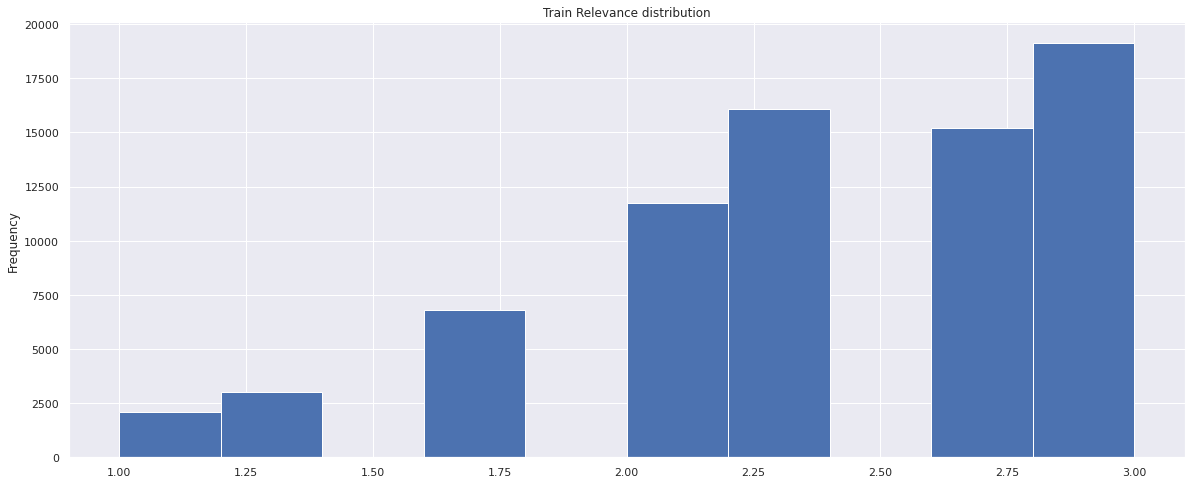

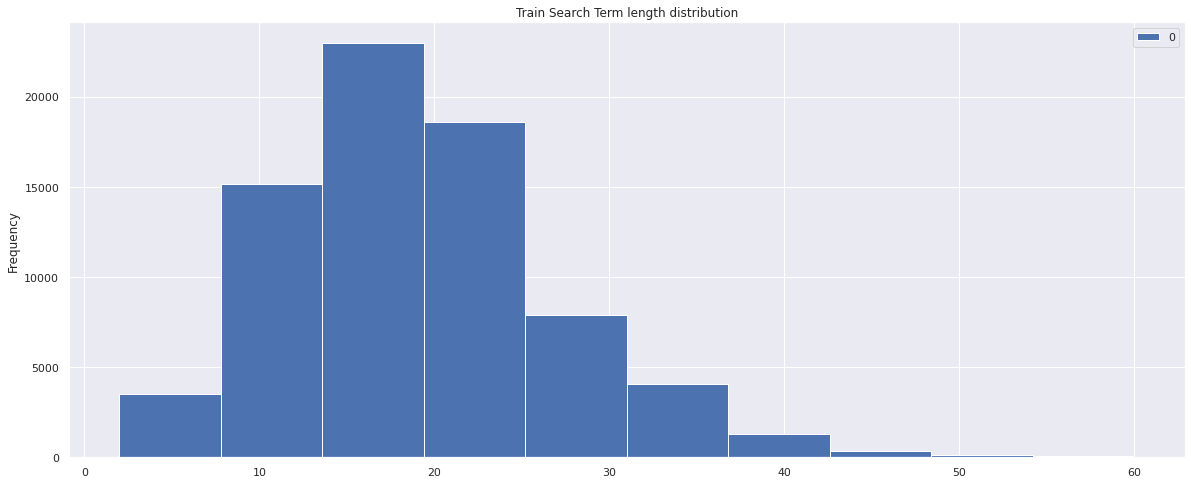

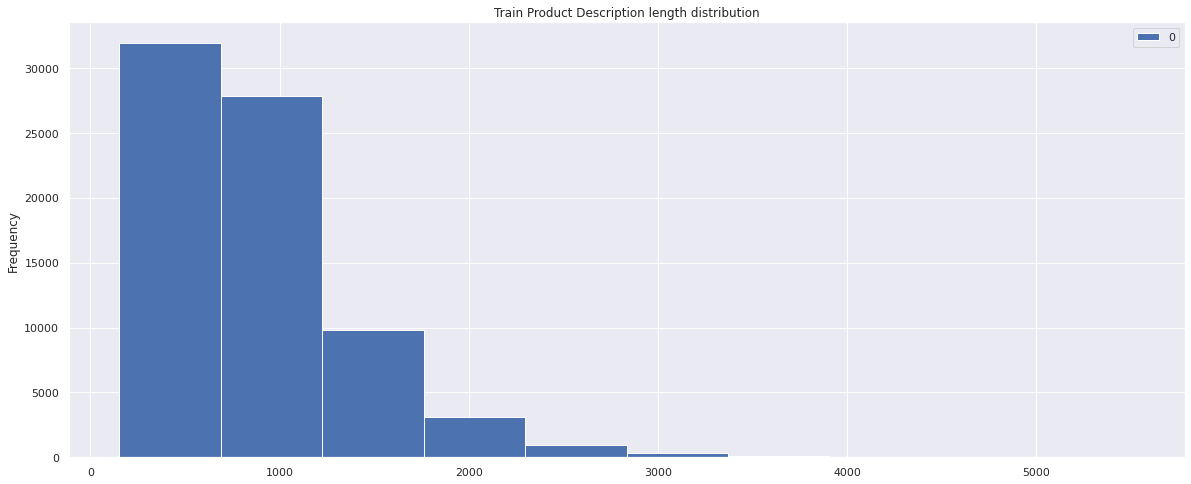

In [103]:
statistic_info(all_train_data_with_desc,'Train')

Test Search term length:
 mean 18.929319068057502
 max 60
 min 1

Test Product_description length:
 mean 891.1579858477518
 max 5479
 min 8

Test Relevace:
 mean 2.3805248645900994
 max 3.0
 min 1.0
 common 3.0



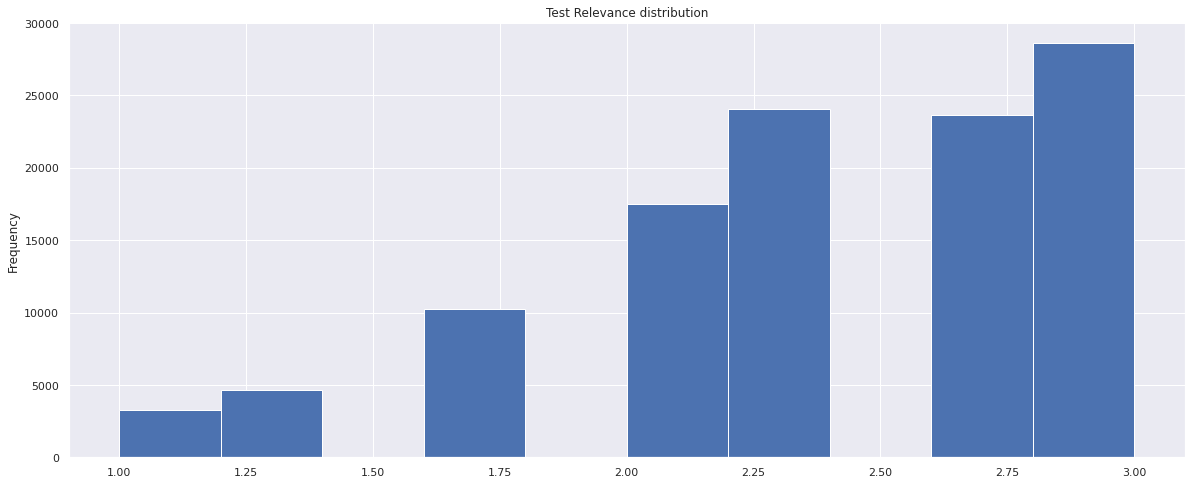

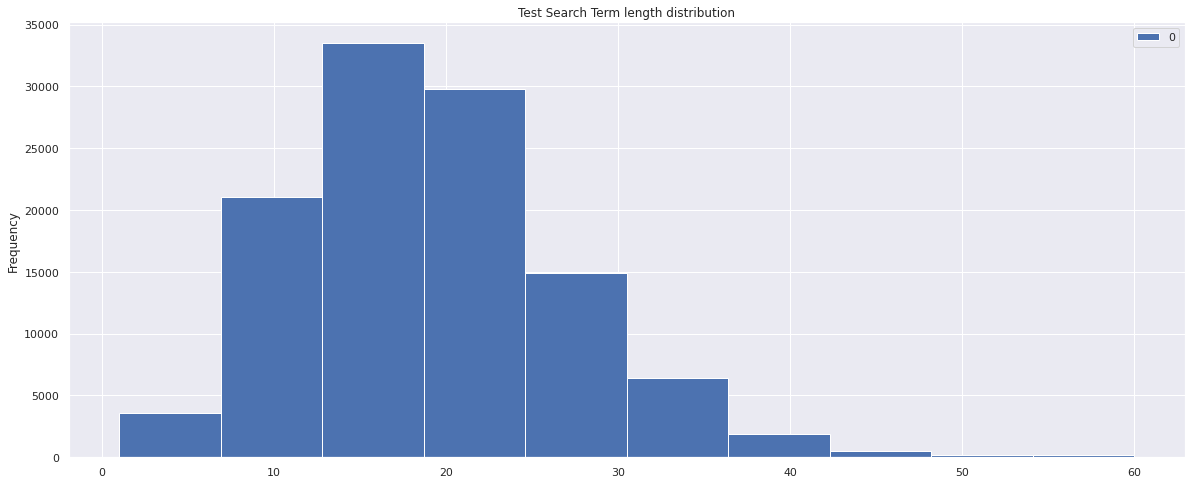

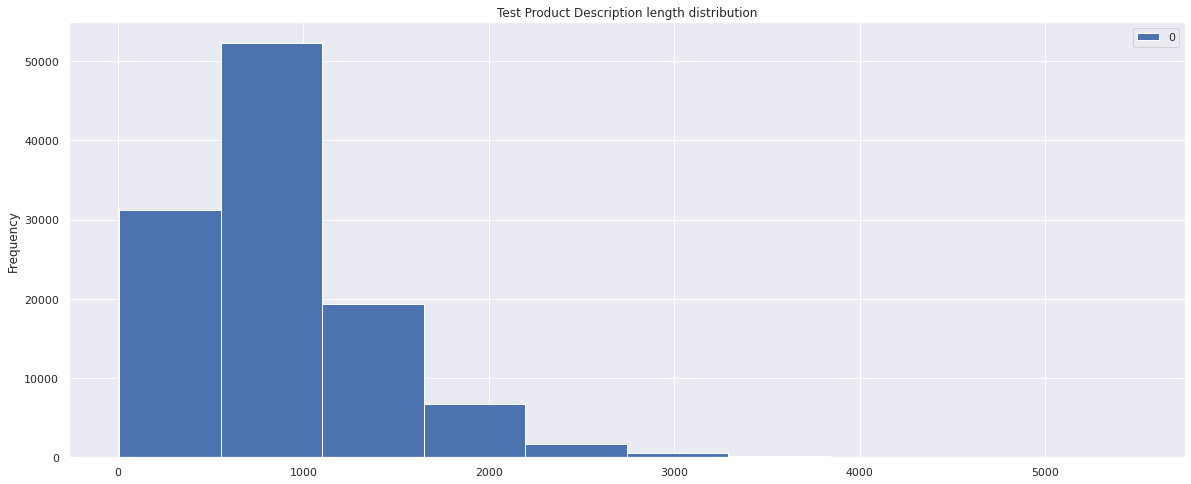

In [104]:
statistic_info(all_test_data_with_desc,'Test')

Now that we have more information about our datasets, we should preprocess the training, validation and testing data to contain sequesnces of single characters:
We turned the query and answer to a list of letter, lowercased all the letter, and filled/ cut the letter list according to the avarage length of a sentence:

In [105]:
data_amount = len(all_train_data_with_desc)
split = data_amount*4//5

# all_train_data_with_desc = all_train_data_with_desc[:data_amount] ## change with number of choosing
# all_test_data_with_desc = all_test_data_with_desc[:data_amount]

standard = preprocessing.StandardScaler()

def preprocces_df(df,mean_q,mean_a):
    pre_q = []
    pre_a = []
    pre_s = []
    for term in df['search_term']:
        l_term = list(term.lower())
        l_term_ascii = []
        for l in l_term:
          l = ord(l)
          l_term_ascii.append(l)
        if len(l_term_ascii) > mean_q:
            l_term_ascii=l_term_ascii[:mean_q]
        else:
            l_term_ascii+=[0] * (mean_q-len(term))
        pre_q.append(l_term_ascii)
    for term in df['product_description']:
        l_term = list(term.lower())
        l_term_ascii = []
        for l in l_term:
          l = ord(l)
          l_term_ascii.append(l)
        if len(l_term_ascii) > mean_a:
            l_term_ascii=l_term_ascii[:mean_a]
        else:
            l_term_ascii+=[0] * (mean_a-len(term))
        pre_a.append(l_term_ascii)
    for score in df['relevance']:
        pre_s.append(score)
    return np.array(pre_q),np.array(pre_a),np.array(pre_s)

df_train_x_q, df_train_x_a, df_train_y = preprocces_df(all_train_data_with_desc,20,885)
df_test_x_q, df_test_x_a, df_test_y = preprocces_df(all_test_data_with_desc,20,885)


val_x_q = standard.fit_transform(df_train_x_q[split:])
val_x_a = standard.fit_transform(df_train_x_a[split:])
val_y = df_train_y[split:]

train_x_q = standard.fit_transform(df_train_x_q[:split])
train_x_a = standard.fit_transform(df_train_x_a[:split])
train_y = df_train_y[:split]

test_x_q = standard.fit_transform(df_test_x_q)
test_x_a = standard.fit_transform(df_test_x_a)
test_y = df_test_y


In [48]:
def plot_model_hist(model_hist):
  train_mse = model_hist.history['loss']
  val_mse = model_hist.history['val_loss']
  train_mae = model_hist.history['mean_absolute_error']
  val_mae = model_hist.history['val_mean_absolute_error']
  train_rmse = model_hist.history['root_mean_squared_error']
  val_rmse = model_hist.history['val_root_mean_squared_error']

  epochs = range(1, len(train_mse) + 1)

  plt.figure(figsize=(45, 6));
  plt.subplot(1, 3, 1)
  plt.plot(epochs, train_mse, color='#eb4d4b', marker='o', linestyle='none', label='Training MSE')
  plt.plot(epochs, val_mse, color='#eb4d4b', label='Validation MSE')
  plt.title('Training and Validation MSE')
  plt.legend(loc='best')
  plt.xlabel('Epochs')
  plt.ylabel('MSE')

  plt.subplot(1, 3, 2)
  plt.plot(epochs, train_mae, color='#eb4d4b', marker='o', linestyle='none', label='Training MAE')
  plt.plot(epochs, val_mae, color='#eb4d4b', label='Validation MAE')
  plt.title('Training and Validation MAE')
  plt.legend(loc='best')
  plt.xlabel('Epochs')
  plt.ylabel('MAE')

  plt.subplot(1, 3, 3)
  plt.plot(epochs, train_rmse, color='#eb4d4b', marker='o', linestyle='none', label='Training RMSE')
  plt.plot(epochs, val_rmse, color='#eb4d4b', label='Validation RMSE')
  plt.title('Training and Validation RMSE')
  plt.legend(loc='best')
  plt.xlabel('Epochs')
  plt.ylabel('RMSE')

  plt.show()


def plot_predictions(pred,y,amount):
  plt.figure(figsize=(15, 8));
  plt.plot(pred[:amount], label='Prediction' )
  plt.plot(y[:amount],c='red',alpha=0.3,  label='Actual')
  plt.legend(loc='best')
  plt.title('Actual VS. Prediction Relevance')
  plt.xlabel('Observation')
  plt.ylabel('Relevance Score')
  plt.show()

## Part 2
Now we will build the siamese model based on the articles provided:

This is the model that each input will go through:

In [4]:
def scores(model,name,train_pred,val_pred,test_pred,y_train,y_val,y_test,runtime,results_df):

    train_mae = mean_absolute_error(y_train, train_pred)
    train_mse = mean_squared_error(y_train, train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))

    val_mae =mean_absolute_error(y_val, val_pred)
    val_mse = mean_squared_error(y_val, val_pred)
    val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))

    test_mae = mean_absolute_error(y_test, test_pred)
    test_mse = mean_squared_error(y_test, test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

    plot_predictions(test_pred,y_test,200)
    row={'Model Name':name, 'Runtime':runtime, 'Train RMSE':train_rmse, 'Val RMSE': val_rmse, 'Test RMSE':test_rmse, 'Train MAE':train_mae, 'Val MAE':val_mae, 'Test MAE':test_mae }
    results_df = results_df.append(row, ignore_index = True)
    return results_df


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 119, 64)           704       
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
activation (Activation)      (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 128)               8320      
Total params: 9,024
Trainable params: 9,024
Non-trainable params: 0
_________________________________________________________________


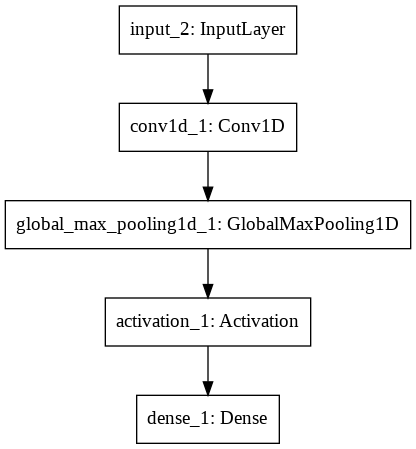

In [45]:
def siamese_branch(input_shape=(128,1)):
    inp = Input(input_shape)
    x = Conv1D(64, (10), activation='relu')(inp)
    x = GlobalMaxPooling1D()(x)
    x = Activation('relu')(x)
    x = Dense(128, activation='sigmoid')(x) 
    return Model(inputs=inp, outputs=x)

siamese_branch((128,1)).summary()
plot_model(siamese_branch((128,1)))

This is the full siamese model that will recive the initail inputs, go through LSTM, go to the siamese branch for each input, and then we'll calculate the euclidian distance, and return the relevance score:

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 20, 1)]      0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 885, 1)]     0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 128)          66560       input_3[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 128)          66560       input_4[0][0]                    
____________________________________________________________________________________________

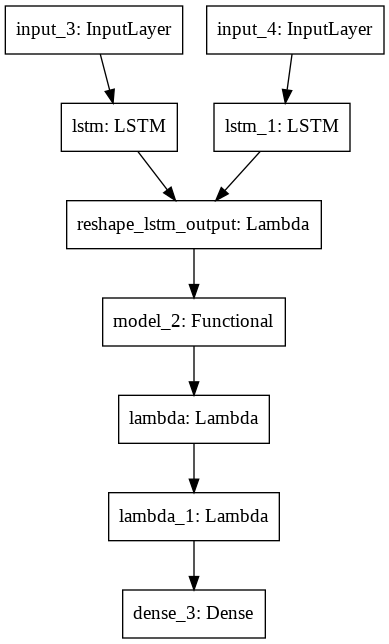

In [46]:
def euclidean_distance(vecs):
    return K.sqrt(K.sum(vecs, axis=1, keepdims=True))

def subs_square(vecs):
    x, y = vecs
    return K.square(x - y)


def siamese_model(input_q_shape,input_a_shape):
    q_input = Input(input_q_shape)
    a_input = Input(input_a_shape)
    LSTM_q = LSTM(128)(q_input)
    LSTM_a = LSTM(128)(a_input)

    reshape_layer = Lambda(lambda tensor: tensor[...,np.newaxis],name="reshape_lstm_output")
    reshape_q = reshape_layer(LSTM_q)
    reshape_a = reshape_layer(LSTM_a)
    
    model = siamese_branch((128,1))
    q_model = model(reshape_q)
    a_model = model(reshape_a)

    Similarity_layer = Lambda(subs_square)([q_model, a_model])
    Similarity_layer_distance = Lambda(euclidean_distance)(Similarity_layer)

    output = Dense(1,activation='relu')(Similarity_layer_distance)
    siamese_model = Model(inputs=[q_input,a_input],outputs=output)
    return siamese_model
model = siamese_model((20,1),(885,1))
model.summary()
model.compile(loss='mse', optimizer='adam', metrics=[MeanAbsoluteError(),RootMeanSquaredError()])
plot_model(model)

In [112]:
history = model.fit([train_x_q,train_x_a], train_y, validation_data = ([val_x_q,val_x_a], val_y), epochs = 30, batch_size=128)

Epoch 1/30
463/463 [==============================] - 120s 252ms/step - loss: 1.0537 - mean_absolute_error: 0.7343 - root_mean_squared_error: 0.9537 - val_loss: 0.3229 - val_mean_absolute_error: 0.4541 - val_root_mean_squared_error: 0.5683
Epoch 2/30
463/463 [==============================] - 116s 250ms/step - loss: 0.2754 - mean_absolute_error: 0.4330 - root_mean_squared_error: 0.5247 - val_loss: 0.3030 - val_mean_absolute_error: 0.4380 - val_root_mean_squared_error: 0.5504
Epoch 3/30
463/463 [==============================] - 116s 250ms/step - loss: 0.2803 - mean_absolute_error: 0.4373 - root_mean_squared_error: 0.5294 - val_loss: 0.3195 - val_mean_absolute_error: 0.4505 - val_root_mean_squared_error: 0.5653
Epoch 4/30
463/463 [==============================] - 115s 249ms/step - loss: 0.2768 - mean_absolute_error: 0.4332 - root_mean_squared_error: 0.5261 - val_loss: 0.3001 - val_mean_absolute_error: 0.4347 - val_root_mean_squared_error: 0.5478
Epoch 5/30
463/463 [====================

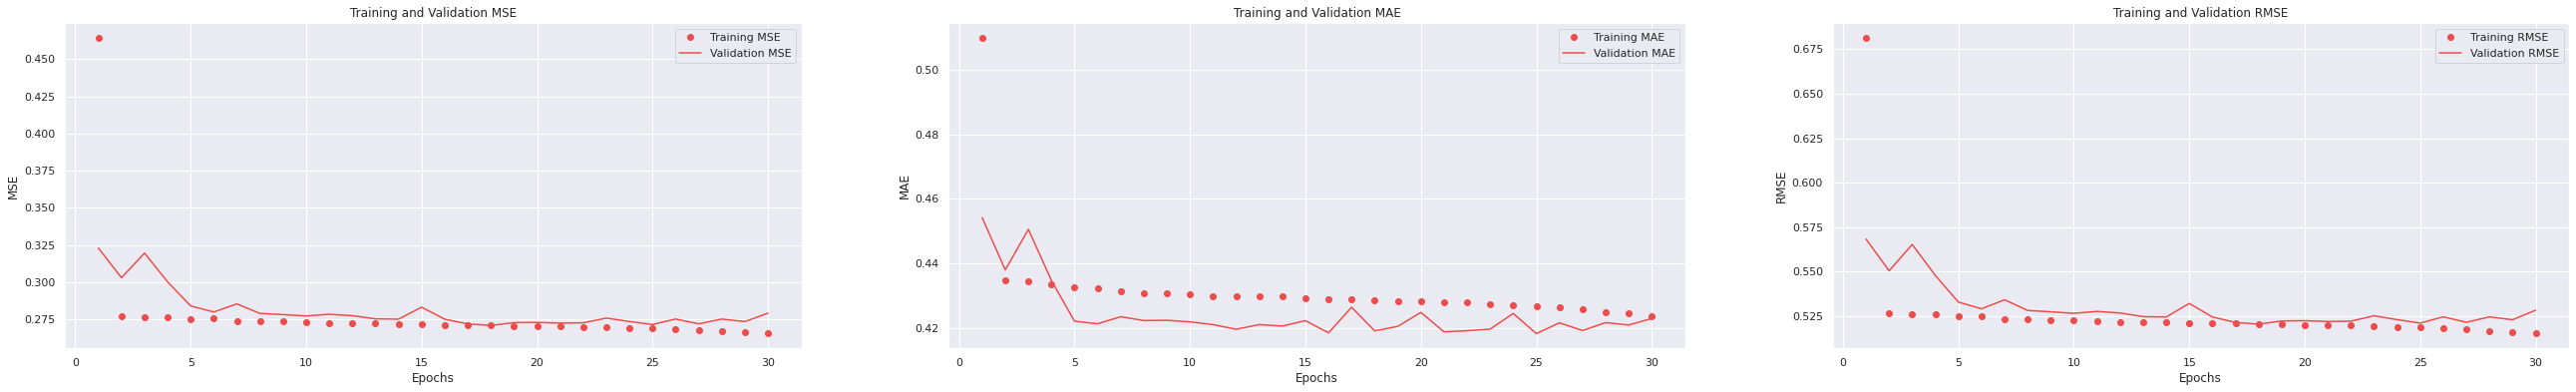

In [119]:
plot_model_hist(history)

After some overfitting issues we found that by standarding the data we can get rid of it.
We used relu as the output of the model, to predict a numeric value, that we'll compare to y relevance value.




In [120]:
train_pred = model.predict([np.expand_dims(train_x_q,2),np.expand_dims(train_x_a,2)])
val_pred = model.predict([np.expand_dims(val_x_q,2),np.expand_dims(val_x_a,2)])
start_time = time.time()
test_pred = model.predict([np.expand_dims(test_x_q,2),np.expand_dims(test_x_a,2)])
runtime = time.time() - start_time

Basic model results:


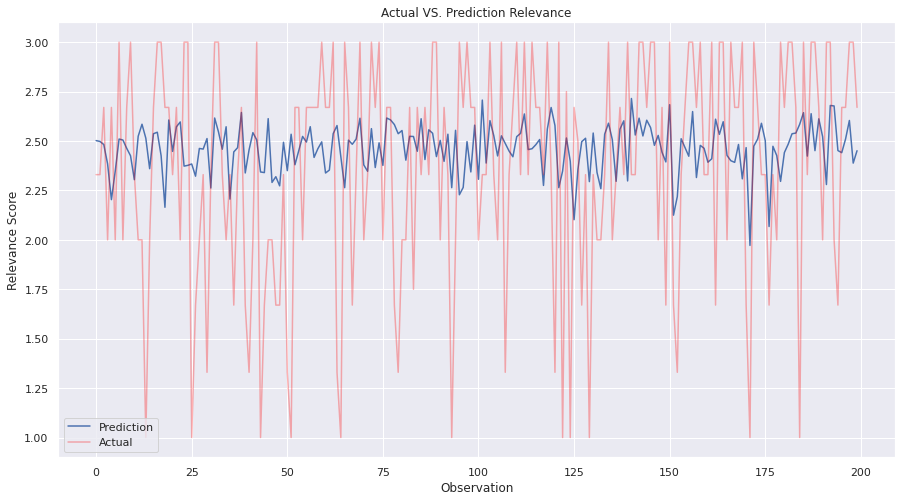

In [139]:
results_df = scores(model,'LSTM Character Level - Simple Siamese Model',train_pred,val_pred,test_pred,train_y,val_y,test_y,runtime,results_df)


In [140]:
results_df.set_index('Model Name')

,Runtime,Train RMSE,Val RMSE,Test RMSE,Train MAE,Val MAE,Test MAE
Model Name,,,,,,,
LSTM Character Level - Simple Siamese Model,226.841804,0.514194,0.528296,0.53317,0.419383,0.422929,0.432371


We will try to improve the model by adding convolutional layers, regularizing the kernel and changing the loss function:

In [47]:
def siamese_branch_improved(input_shape=(128,1)):
    inp = Input(input_shape)
    x = Conv1D(64, 10, activation='relu')(inp) 
    x = MaxPooling1D()(x)
    x = Conv1D(128, 7, activation='relu')(inp) 
    x = MaxPooling1D()(x)
    x = Conv1D(128, 4, activation='relu')(inp) 
    x = MaxPooling1D()(x)
    x = Conv1D(256, 4, activation='relu')(inp) 
    x = MaxPooling1D()(x)
    x = Flatten()(x)
    x = Dense(4096, activation='sigmoid')(x)
    return Model(inputs=inp, outputs=x)

def siamese_model_improved(input_q_shape,input_a_shape):
    q_input = Input(input_q_shape)
    a_input = Input(input_a_shape)
    LSTM_q = LSTM(128)(q_input)
    LSTM_a = LSTM(128)(a_input)

    reshape_layer = Lambda(lambda tensor: tensor[...,np.newaxis],name="reshape_lstm_output")
    reshape_q = reshape_layer(LSTM_q)
    reshape_a = reshape_layer(LSTM_a)
    
    model = siamese_branch_improved((128,1))
    q_model = model(reshape_q)
    a_model = model(reshape_a)

    Similarity_layer = Lambda(subs_square)([q_model, a_model])
    Similarity_layer_distance = Lambda(euclidean_distance)(Similarity_layer)
    
    output = Dense(1,activation='relu')(Similarity_layer_distance) 
    siamese_model = Model(inputs=[q_input,a_input],outputs=output)
    return siamese_model

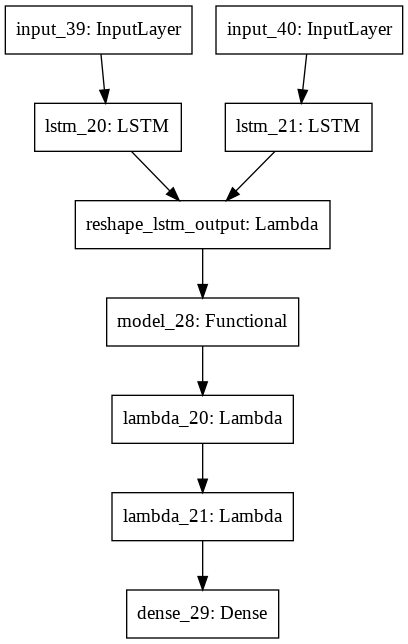

In [142]:
improved_model = siamese_model_improved((20,1),(885,1))
improved_model.compile(loss='mse', optimizer='adam', metrics=[MeanAbsoluteError(),RootMeanSquaredError()])
plot_model(model)

In [143]:
history = improved_model.fit([train_x_q,train_x_a], train_y, validation_data = ([val_x_q,val_x_a], val_y), epochs = 30, batch_size=128)

Epoch 1/30
463/463 [==============================] - 174s 367ms/step - loss: 0.4636 - mean_absolute_error: 0.5207 - root_mean_squared_error: 0.6571 - val_loss: 0.5115 - val_mean_absolute_error: 0.5602 - val_root_mean_squared_error: 0.7152
Epoch 2/30
463/463 [==============================] - 169s 365ms/step - loss: 0.2838 - mean_absolute_error: 0.4377 - root_mean_squared_error: 0.5327 - val_loss: 0.4770 - val_mean_absolute_error: 0.5367 - val_root_mean_squared_error: 0.6907
Epoch 3/30
463/463 [==============================] - 169s 364ms/step - loss: 0.2816 - mean_absolute_error: 0.4361 - root_mean_squared_error: 0.5307 - val_loss: 0.3826 - val_mean_absolute_error: 0.4911 - val_root_mean_squared_error: 0.6185
Epoch 4/30
463/463 [==============================] - 169s 365ms/step - loss: 0.2847 - mean_absolute_error: 0.4387 - root_mean_squared_error: 0.5335 - val_loss: 0.4546 - val_mean_absolute_error: 0.5281 - val_root_mean_squared_error: 0.6742
Epoch 5/30
463/463 [====================

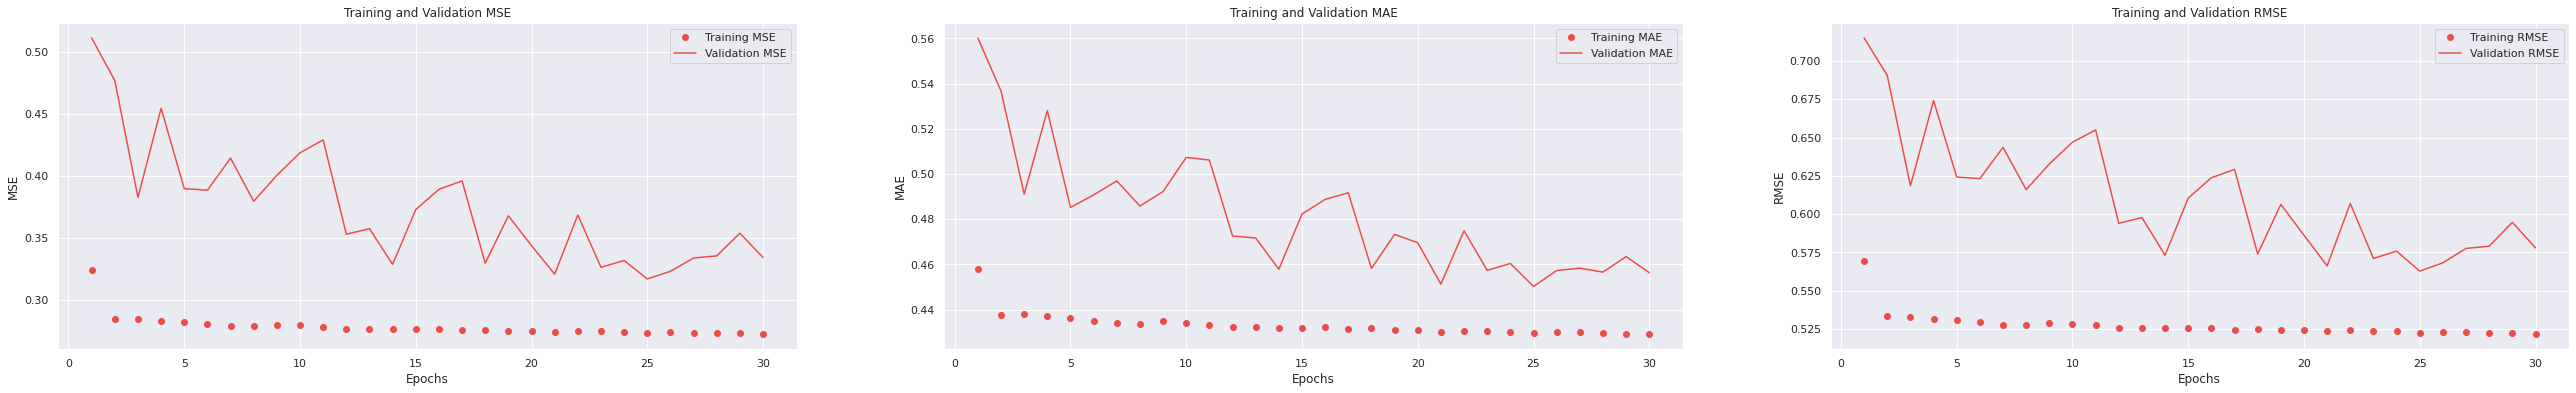

In [144]:
plot_model_hist(history)

In [145]:
train_pred = improved_model.predict([np.expand_dims(train_x_q,2),np.expand_dims(train_x_a,2)])
val_pred = improved_model.predict([np.expand_dims(val_x_q,2),np.expand_dims(val_x_a,2)])
start_time = time.time()
test_pred = improved_model.predict([np.expand_dims(test_x_q,2),np.expand_dims(test_x_a,2)])
runtime = time.time() - start_time

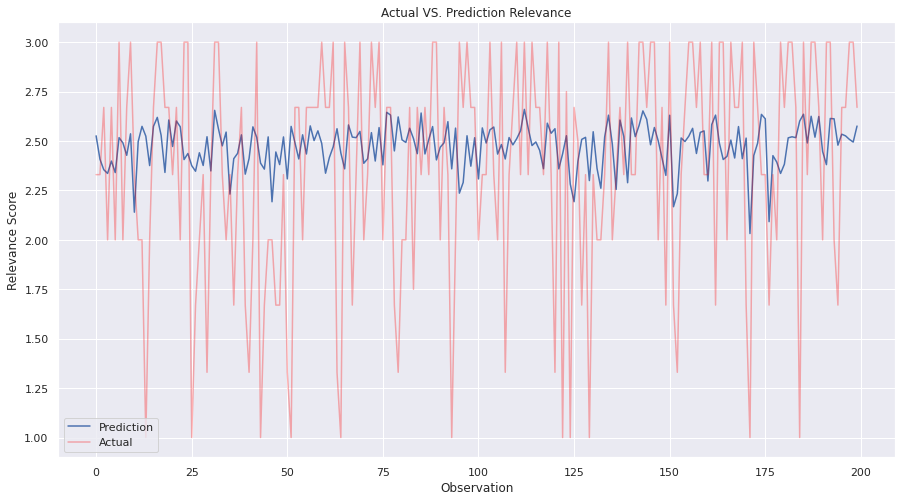

In [146]:
results_df = scores(improved_model,'LSTM Character Level - Complex Siamese Model',train_pred,val_pred,test_pred,train_y,val_y,test_y,runtime,results_df)

In [147]:
results_df.set_index('Model Name')

,Runtime,Train RMSE,Val RMSE,Test RMSE,Train MAE,Val MAE,Test MAE
Model Name,,,,,,,
LSTM Character Level - Simple Siamese Model,226.841804,0.514194,0.528296,0.533170,0.419383,0.422929,0.432371
LSTM Character Level - Complex Siamese Model,268.791917,0.520142,0.578006,0.533278,0.426692,0.456363,0.431324


We found out that a more complex model did not helped to improve our results - and mainly caused overfitting. We will stick to our original model for now, and try and use this one again with word embedding later...

## Part 3
We will now create some model-based benchmarks to compare to out network:

We will start with Count vectorized - Convert a collection of letters lists to a matrix of token counts, to combine the two inputs to one for it to be able to become input for ML model:

In [148]:

cv = CountVectorizer(analyzer='char')
X1_train=cv.fit_transform(all_train_data_with_desc.search_term).toarray()
X2_train=cv.transform(all_train_data_with_desc.product_description).toarray()

X1_test=cv.fit_transform(all_test_data_with_desc.search_term).toarray()
X2_test=cv.transform(all_test_data_with_desc.product_description).toarray()

X = np.concatenate((X1_train,X2_train),axis = 1)
X_test =  np.concatenate((X1_test,X2_test),axis = 1)
train_y = df_train_y

X_train, X_val, y_train, y_val = train_test_split(X,train_y, test_size=0.2)



Now we will try to fit and predict with Random Forest Regressor:

In [150]:
rf_reg = RandomForestRegressor(n_estimators=5, max_depth = 5)
rf_reg.fit(X_train, y_train)

train_pred = rf_reg.predict(X_train)
val_pred = rf_reg.predict(X_val)
start_time = time.time()
test_pred = rf_reg.predict(X_test)
runtime = time.time() - start_time


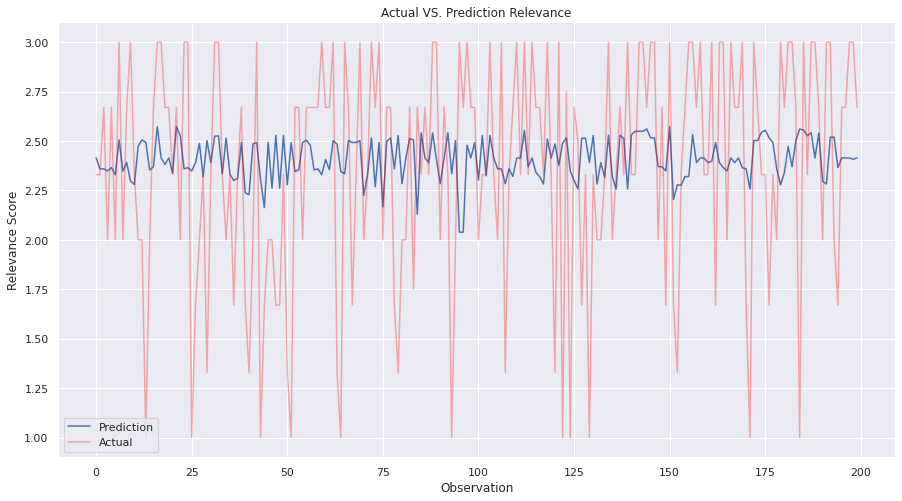

In [152]:
results_df = scores(rf_reg,'Benchmark RandomForest',train_pred,val_pred,test_pred,y_train,y_val,test_y,runtime,results_df)

In [153]:
results_df.set_index('Model Name')

,Runtime,Train RMSE,Val RMSE,Test RMSE,Train MAE,Val MAE,Test MAE
Model Name,,,,,,,
LSTM Character Level - Simple Siamese Model,226.841804,0.514194,0.528296,0.533170,0.419383,0.422929,0.432371
LSTM Character Level - Complex Siamese Model,268.791917,0.520142,0.578006,0.533278,0.426692,0.456363,0.431324
Benchmark RandomForest,0.068968,0.521072,0.526278,0.527402,0.426041,0.430345,0.430705


Now we will try to fit and predict with XGB Regressor:

In [154]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,max_depth = 3, alpha = 10, n_estimators = 5)
xg_reg.fit(X_train, y_train)

train_pred = xg_reg.predict(X_train)
val_pred = xg_reg.predict(X_val)
start_time = time.time()
test_pred = xg_reg.predict(X_test)
runtime = time.time() - start_time

[16:31:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


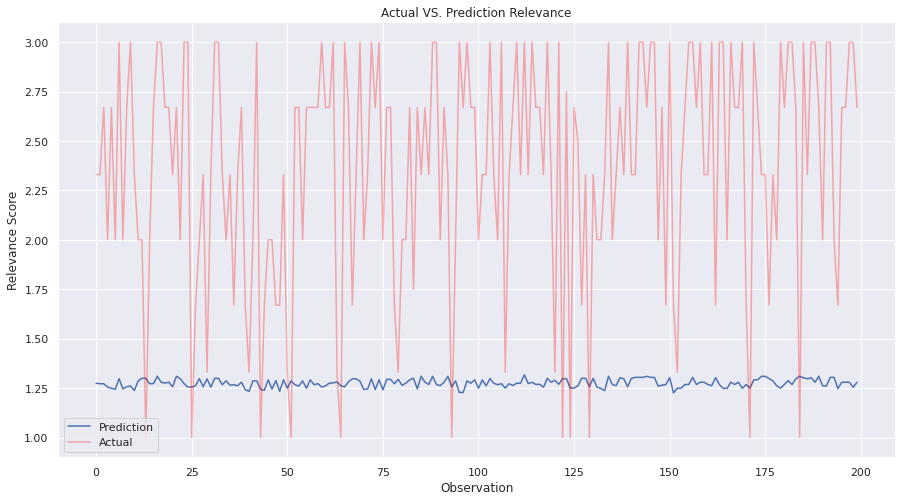

In [155]:
results_df = scores(xg_reg,'Benchmark XGB',train_pred,val_pred,test_pred,y_train,y_val,test_y,runtime,results_df)

In [156]:
results_df.set_index('Model Name')

,Runtime,Train RMSE,Val RMSE,Test RMSE,Train MAE,Val MAE,Test MAE
Model Name,,,,,,,
LSTM Character Level - Simple Siamese Model,226.841804,0.514194,0.528296,0.533170,0.419383,0.422929,0.432371
LSTM Character Level - Complex Siamese Model,268.791917,0.520142,0.578006,0.533278,0.426692,0.456363,0.431324
Benchmark RandomForest,0.068968,0.521072,0.526278,0.527402,0.426041,0.430345,0.430705
Benchmark XGB,0.107799,1.230849,1.234210,1.230990,1.125867,1.128628,1.125417


We can see that our model peformes better than the XGBRegressor, and the same as the Random Forest Regressor which can be marked as a strong benchmark.

## Part 4
In this part we will use our best siamese model from part 2 as a feature extractor for an ML model.

We will implement it with Random Forest Regressor and K Neighbors Regressor:


In [158]:
FE_model = model
FE_model.summary()

val_x_q = df_train_x_q[split:]
val_x_a = df_train_x_a[split:]
val_y = df_train_y[split:]

train_x_q = df_train_x_q[:split]
train_x_a = df_train_x_a[:split]
train_y = df_train_y[:split]

test_x_q = df_test_x_q
test_x_a = df_test_x_a
test_y = df_test_y

FE_train = FE_model.predict([train_x_q,train_x_a]) 
FE_val = FE_model.predict([val_x_q, val_x_a]) 
FE_test = FE_model.predict([test_x_q,test_x_a]) 

Model: "model_29"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_39 (InputLayer)           [(None, 20, 1)]      0                                            
__________________________________________________________________________________________________
input_40 (InputLayer)           [(None, 885, 1)]     0                                            
__________________________________________________________________________________________________
lstm_20 (LSTM)                  (None, 128)          66560       input_39[0][0]                   
__________________________________________________________________________________________________
lstm_21 (LSTM)                  (None, 128)          66560       input_40[0][0]                   
___________________________________________________________________________________________

In [159]:
rf_reg = RandomForestRegressor(n_estimators=10, max_depth = 5)
rf_reg.fit(FE_train, train_y)

train_pred = rf_reg.predict(FE_train)
val_pred = rf_reg.predict(FE_val)
start_time = time.time()
test_pred = rf_reg.predict(FE_test)
runtime = time.time() - start_time

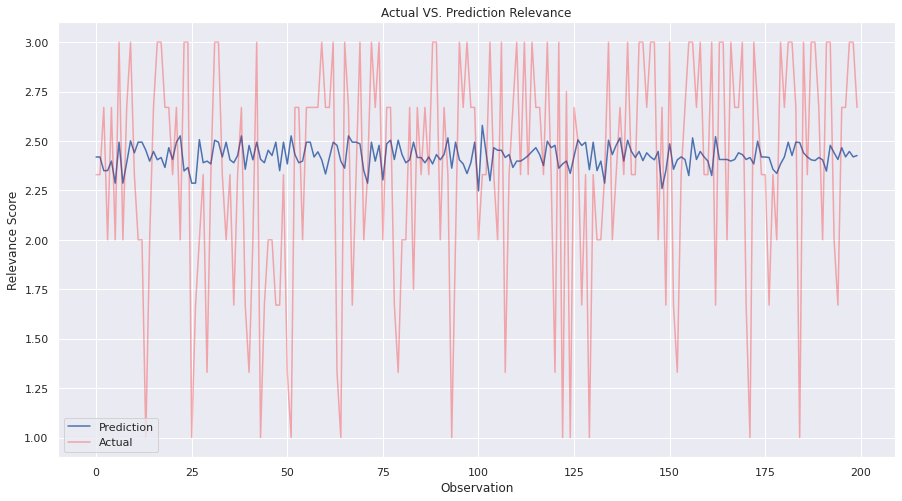

In [160]:
results_df = scores(rf_reg,'FE & RandomForest',train_pred,val_pred,test_pred,train_y,val_y,test_y,runtime,results_df)

In [161]:
results_df.set_index('Model Name')

,Runtime,Train RMSE,Val RMSE,Test RMSE,Train MAE,Val MAE,Test MAE
Model Name,,,,,,,
LSTM Character Level - Simple Siamese Model,226.841804,0.514194,0.528296,0.533170,0.419383,0.422929,0.432371
LSTM Character Level - Complex Siamese Model,268.791917,0.520142,0.578006,0.533278,0.426692,0.456363,0.431324
Benchmark RandomForest,0.068968,0.521072,0.526278,0.527402,0.426041,0.430345,0.430705
Benchmark XGB,0.107799,1.230849,1.234210,1.230990,1.125867,1.128628,1.125417
FE & RandomForest,0.044175,0.525604,0.548533,0.534388,0.433839,0.434072,0.436724


In [162]:
KNN_reg = KNeighborsRegressor(n_neighbors=2)
KNN_reg.fit(FE_train, train_y)

train_pred = KNN_reg.predict(FE_train)
val_pred = KNN_reg.predict(FE_val)
start_time = time.time()
test_pred = KNN_reg.predict(FE_test)
runtime = time.time() - start_time

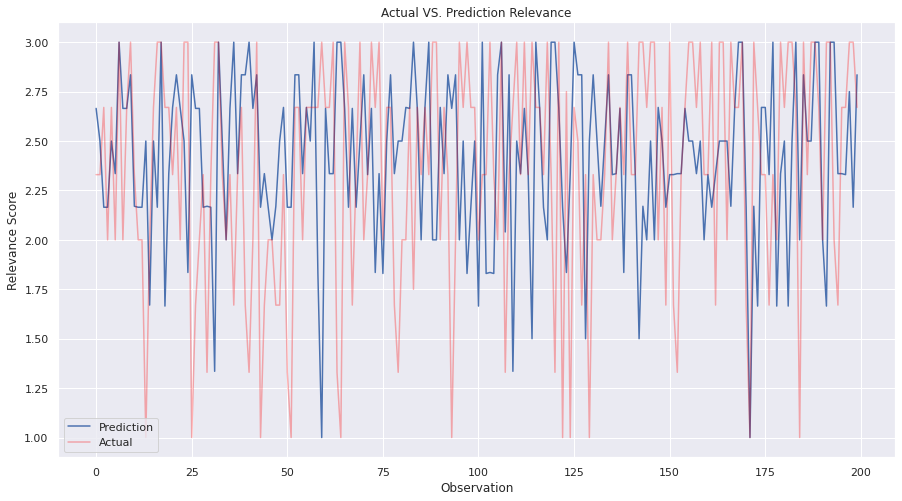

In [163]:
results_df = scores(KNN_reg,'FE & KNeighbors',train_pred,val_pred,test_pred,train_y,val_y,test_y,runtime,results_df)

In [164]:
results_df.set_index('Model Name')

,Runtime,Train RMSE,Val RMSE,Test RMSE,Train MAE,Val MAE,Test MAE
Model Name,,,,,,,
LSTM Character Level - Simple Siamese Model,226.841804,0.514194,0.528296,0.533170,0.419383,0.422929,0.432371
LSTM Character Level - Complex Siamese Model,268.791917,0.520142,0.578006,0.533278,0.426692,0.456363,0.431324
Benchmark RandomForest,0.068968,0.521072,0.526278,0.527402,0.426041,0.430345,0.430705
Benchmark XGB,0.107799,1.230849,1.234210,1.230990,1.125867,1.128628,1.125417
FE & RandomForest,0.044175,0.525604,0.548533,0.534388,0.433839,0.434072,0.436724
FE & KNeighbors,0.180477,0.397274,0.611859,0.649485,0.295012,0.479093,0.512002


The feature extractor did not seem to improve our result, but it made us beleive that by taking the search query as letters instead of words, is not the ideal way of learning the relevance, and its RMSE improvment is probably bounded.
We will now try to fit the model on words instead of letters.

# Word embeddings and word level LSTM



In charge - Peleg Biton & Omer Nagar

## Part 1


In this section we are about to load the data again and preprocess the data to create tokens of words.

Train records -

In [15]:
all_train_data = pd.read_csv(path+'train.csv/train.csv', encoding='latin-1')
all_train_data

,id,product_uid,product_title,search_term,relevance
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67
...,...,...,...,...,...
74062,221457,206638,Atlantic Windowpane 576 CD or 192 DVD Blu-Ray ...,tv riser glass,1.00
74063,221458,206639,Philips 40-Watt Halogen R20 Flood Light Bulb (...,r20 halogen light,3.00
74064,221463,206641,Schlage Camelot In-Active Aged Bronze Handlese...,schlage lock siena half dummy knob with,2.33
74065,221471,206648,Plastec 11 in. x 24 in. Rose Garden Wall Decor...,zen garden decor,3.00


Test Records - 

In [17]:
test_df = pd.read_csv(path+'test.csv/test.csv', encoding='latin-1')
test_df

,id,product_uid,product_title,search_term
0,1,100001,Simpson Strong-Tie 12-Gauge Angle,90 degree bracket
1,4,100001,Simpson Strong-Tie 12-Gauge Angle,metal l brackets
2,5,100001,Simpson Strong-Tie 12-Gauge Angle,simpson sku able
3,6,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong ties
4,7,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong tie hcc668
...,...,...,...,...
166688,240756,224424,stufurhome Norma 24 in. W x 16 in. D x 34 in. ...,24 whtie storage cabinet
166689,240757,224425,Home Decorators Collection 49 in. D Alessandro...,adirondeck cusion
166690,240758,224426,Simpson Strong-Tie HB 3-1/2 x 14 in. Top Flang...,hb
166691,240759,224427,1/4 in. -20 tpi x 1-1/2 in. Stainless Steel Bu...,hex sockets


Product descriptions -

In [16]:
all_product_descriptions = pd.read_csv(path+'product_descriptions.csv/product_descriptions.csv', encoding='latin-1')
all_product_descriptions

,product_uid,product_description
0,100001,"Not only do angles make joints stronger, they ..."
1,100002,BEHR Premium Textured DECKOVER is an innovativ...
2,100003,Classic architecture meets contemporary design...
3,100004,The Grape Solar 265-Watt Polycrystalline PV So...
4,100005,Update your bathroom with the Delta Vero Singl...
...,...,...
124423,224424,Create a neat yet stylish storage space for or...
124424,224425,Our Bullnose Adirondack Chair Cushions fit Adi...
124425,224426,Joist hangers are designed to provide support ...
124426,224427,These socket cap screws are ideal for applicat...


Test actual results from Kaggle - 

In [18]:
solution_df = pd.read_csv(path+'solution.csv', encoding='latin-1')
solution_df

,id,relevance,Usage
0,1,-1.00,Ignored
1,4,2.33,Public
2,5,2.33,Private
3,6,2.67,Private
4,7,2.00,Public
...,...,...,...
166688,240756,-1.00,Ignored
166689,240757,-1.00,Ignored
166690,240758,-1.00,Ignored
166691,240759,-1.00,Ignored


We will use 20% of the train records as validation - 

In [19]:
train_df, val_df = train_test_split(all_train_data, test_size=0.2, random_state=2018)
train_df.shape, val_df.shape, test_df.shape

((59253, 5), (14814, 5), (166693, 4))

Organize the data & join product queries relevance table with description table -

In [20]:
train_joined_df = pd.merge(train_df, all_product_descriptions, on='product_uid', how='left')
val_joined_df = pd.merge(val_df, all_product_descriptions, on='product_uid', how='left')
test_joined_df = pd.merge(test_df, all_product_descriptions, on='product_uid', how='left')
test_joined_df = pd.merge(test_joined_df, solution_df, on='id', how='left')
test_joined_df = test_joined_df[test_joined_df["Usage"]!='Ignored']
train_joined_df.shape, val_joined_df.shape, test_joined_df.shape

((59253, 6), (14814, 6), (112067, 7))

In [21]:
train_X_query = pd.Series([rec.lower() for rec in train_joined_df['search_term'].fillna("_na_")]).values
train_X_description = pd.Series([rec.lower() for rec in train_joined_df['product_description'].fillna("_na_")]).values

We will use gensim.utils.simple_preprocess to create lowercase tokens & create a dictionary of unique tokens from our train records - both queries and descriptions, to get the number of unique tokens - 

In [22]:
class MyCorpus(object):
    def __init__(self, array):
        self.array = array
    def __iter__(self):
        stoplist = set('for a of the and to in'.split())
        for line in self.array:
            # assume there's one document per line, tokens separated by whitespace
            yield [word for word in gensim.utils.simple_preprocess(line) if word not in stoplist]

In [23]:
train_W2V = MyCorpus(train_X_query + train_X_description)

In [24]:
from gensim import corpora
dictionary = corpora.Dictionary(train_W2V)
print(dictionary)

Dictionary(128625 unique tokens: ['able', 'all', 'at', 'be', 'blades']...)


## Part 2

First, we will calculate the square root of the dictionary size and will 'round' the value. We will use it as our embbeding size - 

In [25]:
size = np.sqrt(len(dictionary.keys()))
size

358.64327680858594

In [26]:
embbeding_size = 360

Create word embbeding model using Word2Vec & train it-

In [27]:
model = gensim.models.Word2Vec(
    train_W2V,
    size=embbeding_size,
    window=5,
    min_count=2,
    workers=10)
model.train(train_W2V, total_examples=(len(train_X_query)+len(train_X_description)), epochs=10)

(60722561, 65559140)

We will now create a Data Generator to hold our embbeded corpuses - train, validation & test - 

In [28]:
train_joined_df2 = train_joined_df[['search_term','product_description','relevance']]
val_joined_df2 = val_joined_df[['search_term','product_description','relevance']]
test_joined_df2 = test_joined_df[['search_term','product_description','relevance']]


In [29]:
train_joined_df2

,search_term,product_description,relevance
0,pre cut riser,Replacing the cutting line on your Sun Joe Shr...,1.67
1,20 gals air-compressors,Powermate 20 Gal. compressor features a cast i...,3.00
2,interior door hardware by schlage,The Plymouth front entry features a simple cur...,3.00
3,ourdoor patio tile,The 12 slat design is our best selling product...,3.00
4,12' square grate,The NDS 12 in. Structural Foam Polyolefin Grat...,3.00
...,...,...,...
59248,proluxe log and siding stain,Rubbol Solid Wood Finish offers excellent dura...,2.33
59249,whirlpool dishwasher white,From baked-on casserole dishes to drinking gla...,3.00
59250,bathroom light fixture 3 bulb,The 3-Light Oil Rubbed Bronze Vanity from Hamp...,2.00
59251,water sealer glue,"KILZ PREMIUM primer is a superior quality, int...",2.00


In [30]:
val_joined_df2

,search_term,product_description,relevance
0,dental shelf door,This Fir Fiberglass Front Door unit comes with...,3.00
1,led bulb 60w bright white,The Polaroid 800 Lumen warm white LED light bu...,2.00
2,pex tube,SharkBite PEX is a cross-linked polyethylene t...,2.33
3,weber cover,Safeguard your Weber Genesis gas grill with th...,2.33
4,31 bathroom vanity,Add a warm and elegant touch to your bathroom ...,2.00
...,...,...,...
14809,canvas drop cloth,Professional grade heavy weight butyl drop clo...,3.00
14810,22 inch florcant,The Hamilton Double Vanity from Home Decorator...,1.00
14811,Vertical storage rubbermaid,The Rubbermaid 2 ft. 1 in. x 2 ft. 6 in. Verti...,2.33
14812,furnace filters 10,The Flanders Flat Panel EZ flow is a standard ...,2.33


In [31]:
test_joined_df2

,search_term,product_description,relevance
1,metal l brackets,"Not only do angles make joints stronger, they ...",2.33
2,simpson sku able,"Not only do angles make joints stronger, they ...",2.33
3,simpson strong ties,"Not only do angles make joints stronger, they ...",2.67
4,simpson strong tie hcc668,"Not only do angles make joints stronger, they ...",2.00
6,bath and shower kit,Classic architecture meets contemporary design...,2.67
...,...,...,...
147401,roof nailing gun,The CN445R2 is the latest version of the MAX S...,2.33
147402,kitchen pro grout,The GROHE Ladylux 3 Pro Single-Handle Pull-Out...,1.00
147403,tilekit 30 x 60 wall bone,The Tile Kit bathtub wall set has a tile-like ...,2.67
147404,light switchvers for little girls,Your daughter will be a queen ready to cast he...,1.00


In [32]:
class MyEmbeddedCorpus(object):
    def __init__(self, df, word_vectors,model):
        self.df = df
        self.word_vectors = word_vectors
        self.model = model
    def __iter__(self):
        for index, row in self.df.iterrows():
            querywordList = [word for word in gensim.utils.simple_preprocess(row['search_term'])]
            querywordList = [word.lower() for word in querywordList if word.lower() in self.word_vectors.vocab]
            embquery= [self.model.wv.get_vector(word) for word in querywordList]
            descwordList = [word for word in gensim.utils.simple_preprocess(row['product_description'])]
            descwordList = [word.lower() for word in descwordList if word.lower() in self.word_vectors.vocab]
            embdesc= [self.model.wv.get_vector(word) for word in descwordList]
            yield [embquery, embdesc] , row['relevance']


In [33]:
word_vectors = model.wv

In [34]:
train_emb = MyEmbeddedCorpus(train_joined_df2,word_vectors,model)
val_emb = MyEmbeddedCorpus(val_joined_df2,word_vectors,model)
test_emb = MyEmbeddedCorpus(test_joined_df2,word_vectors,model)

We will check the distribution of the length of our two inputs to decide what padding size to use - 

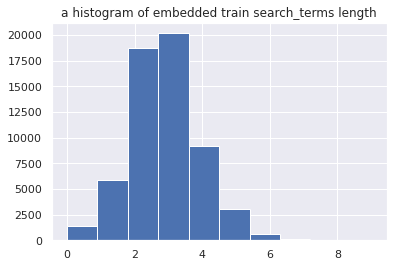

In [35]:
_ = plt.hist([len(x[0][0]) for x in train_emb])
_ = plt.title('a histogram of embedded train search_terms length')

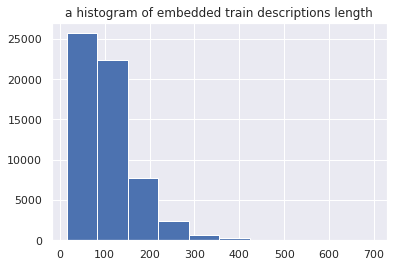

In [36]:
_ = plt.hist([len(x[0][1]) for x in train_emb])
_ = plt.title('a histogram of embedded train descriptions length')

In [37]:
train_X_query_lens = [len(x[0][0]) for x in train_emb]
train_X_description_lens = [len(x[0][1]) for x in train_emb]

Looking on the Histograms, we decided to use the mean value of our descriptions length to avoid mass of padding, knowing we will lose some words. Query max length is way smaller so we decided to use it as padding size of query - cutting no words from the input.

In [38]:
train_X_query_max_len = round(np.max(train_X_query_lens))
train_X_description_max_len = round(np.mean(train_X_description_lens))
train_X_query_max_len, train_X_description_max_len

(9, 108)

In [39]:
class MyPaddedCorpus(object):
    def __init__(self, corpus , querymaxLen, descmaxLen, embbeding_size):
        self.corpus = corpus
        self.querymaxLen = querymaxLen
        self.descmaxLen = descmaxLen
        self.embbeding_size = embbeding_size
    def __iter__(self):
        for record in self.corpus:
            query = record[0][0]
            qlen = len(query)         
            if qlen < self.querymaxLen:
                padd_len = self.querymaxLen - qlen
                query = np.array(padd_len * [[0]* self.embbeding_size] + query)
            else:
                query = np.array(query[:self.querymaxLen])
            desc = record[0][1]
            dlen = len(desc)         
            if dlen < self.descmaxLen:
                padd_len = self.descmaxLen - dlen
                desc = np.array(padd_len * [[0]* self.embbeding_size] + desc)
            else:
                desc = np.array(desc[:self.descmaxLen])
            yield [np.array(np.expand_dims(query,axis=0)), np.array(np.expand_dims(desc,axis=0))] , np.array(np.expand_dims(record[1],axis=0))
                

In [40]:
train_padd = MyPaddedCorpus(train_emb,train_X_query_max_len,train_X_description_max_len,embbeding_size)
val_padd = MyPaddedCorpus(val_emb,train_X_query_max_len,train_X_description_max_len,embbeding_size)
test_padd = MyPaddedCorpus(test_emb,train_X_query_max_len,train_X_description_max_len,embbeding_size)

## Part 3

We will use the same two siamese models from the Character level LSTM section to predict the relevance between the queries and the descriptions - 

In [41]:
epochs = 32

In [42]:
def DataGenerator(corpus,epochs=100):
    for epoch in range(epochs):
        for record in corpus:
            yield record

In [60]:
def Relevances(corpus):
  res = []
  for record in corpus:
    res.append(record[1])
  return res

In [62]:
train_y = Relevances(train_padd)
val_y = Relevances(val_padd)
test_y = Relevances(test_padd)

In [44]:
train = DataGenerator(train_padd)
val = DataGenerator(val_padd)
test = DataGenerator(test_padd,1)

In [51]:
model = siamese_model((train_X_query_max_len, embbeding_size),(train_X_description_max_len, embbeding_size))
model.summary()
model.compile(loss='mse', optimizer='adam', metrics=[MeanAbsoluteError(),RootMeanSquaredError()])

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 9, 360)]     0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 108, 360)]   0                                            
__________________________________________________________________________________________________
lstm_4 (LSTM)                   (None, 128)          250368      input_9[0][0]                    
__________________________________________________________________________________________________
lstm_5 (LSTM)                   (None, 128)          250368      input_10[0][0]                   
____________________________________________________________________________________________

In [52]:
history = model.fit(train,steps_per_epoch=len(train_joined_df2)//16,validation_data=val, validation_steps=len(val_joined_df2), epochs=epochs)

Epoch 1/32
3703/3703 [==============================] - 115s 30ms/step - loss: 0.7054 - mean_absolute_error: 0.6247 - root_mean_squared_error: 0.7973 - val_loss: 0.3204 - val_mean_absolute_error: 0.4514 - val_root_mean_squared_error: 0.5660
Epoch 2/32
3703/3703 [==============================] - 111s 30ms/step - loss: 0.3048 - mean_absolute_error: 0.4487 - root_mean_squared_error: 0.5520 - val_loss: 0.2952 - val_mean_absolute_error: 0.4426 - val_root_mean_squared_error: 0.5433
Epoch 3/32
3703/3703 [==============================] - 111s 30ms/step - loss: 0.2908 - mean_absolute_error: 0.4447 - root_mean_squared_error: 0.5391 - val_loss: 0.2877 - val_mean_absolute_error: 0.4428 - val_root_mean_squared_error: 0.5364
Epoch 4/32
3703/3703 [==============================] - 112s 30ms/step - loss: 0.2681 - mean_absolute_error: 0.4243 - root_mean_squared_error: 0.5177 - val_loss: 0.2946 - val_mean_absolute_error: 0.4519 - val_root_mean_squared_error: 0.5427
Epoch 5/32
3703/3703 [==============

Metrics over epochs - 

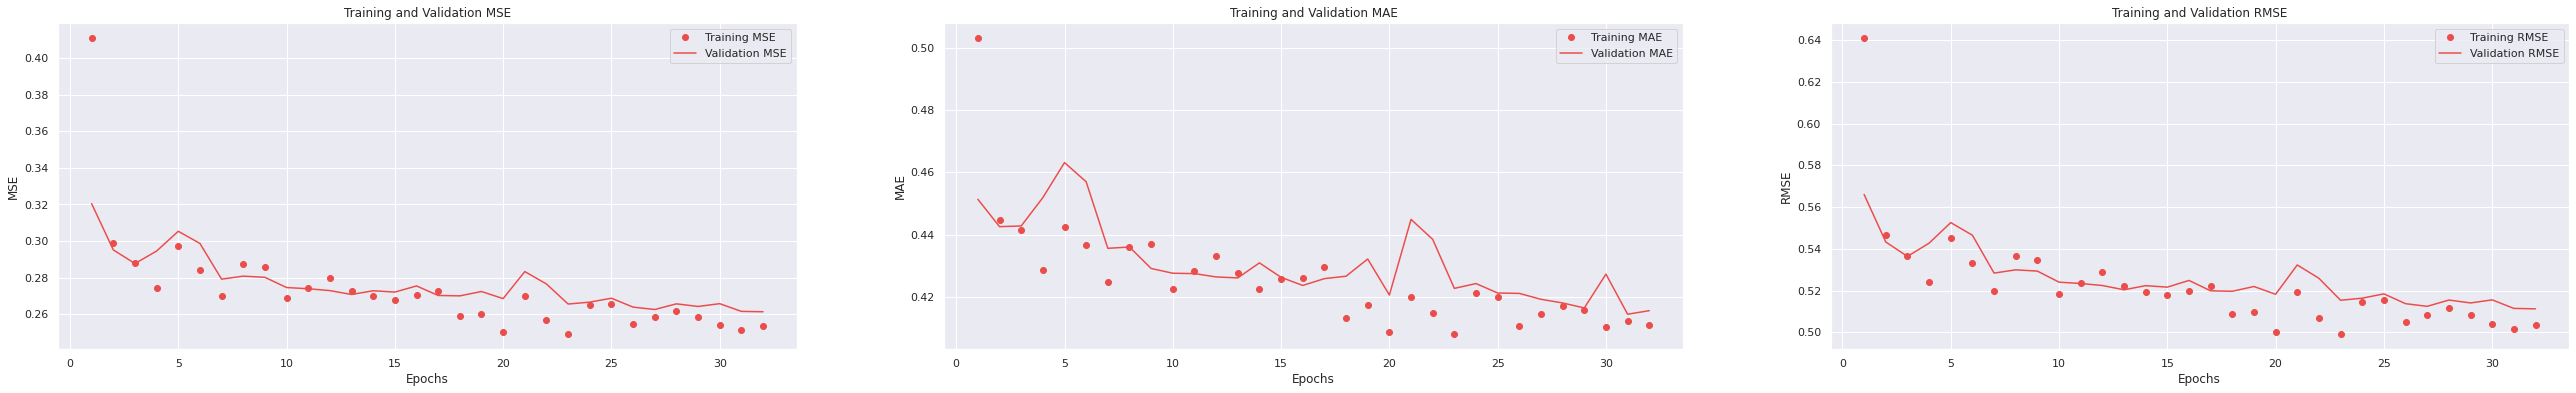

In [53]:
plot_model_hist(history)

In [69]:
train_padd = MyPaddedCorpus(train_emb,train_X_query_max_len,train_X_description_max_len,embbeding_size)
val_padd = MyPaddedCorpus(val_emb,train_X_query_max_len,train_X_description_max_len,embbeding_size)
test_padd = MyPaddedCorpus(test_emb,train_X_query_max_len,train_X_description_max_len,embbeding_size)

In [70]:
train = DataGenerator(train_padd,1)
val = DataGenerator(val_padd,1)
test = DataGenerator(test_padd,1)

In [71]:
train_pred = model.predict(train)
val_pred = model.predict(val)
start_time = time.time()
test_pred = model.predict(test)
runtime = time.time() - start_time


Model test predictions examples -

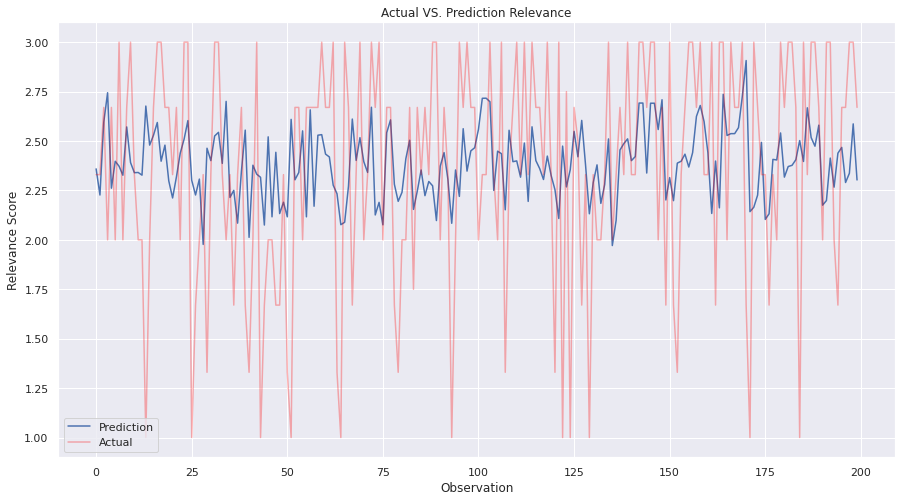

In [72]:
results_df = scores(model,'LSTM Word Level - Simple Siamese Model',train_pred,val_pred,test_pred,train_y,val_y,test_y,runtime,results_df)

Model results comparison -

In [73]:
results_df.set_index('Model Name')

,Runtime,Train RMSE,Val RMSE,Test RMSE,Train MAE,Val MAE,Test MAE
Model Name,,,,,,,
LSTM Character Level - Simple Siamese Model,226.841804,0.514194,0.528296,0.533170,0.419383,0.422929,0.432371
LSTM Character Level - Complex Siamese Model,268.791917,0.520142,0.578006,0.533278,0.426692,0.456363,0.431324
Benchmark RandomForest,0.068968,0.521072,0.526278,0.527402,0.426041,0.430345,0.430705
Benchmark XGB,0.107799,1.230849,1.234210,1.230990,1.125867,1.128628,1.125417
FE & RandomForest,0.044175,0.525604,0.548533,0.534388,0.433839,0.434072,0.436724
FE & KNeighbors,0.180477,0.397274,0.611859,0.649485,0.295012,0.479093,0.512002
LSTM Word Level - Simple Siamese Model,460.64,0.487814,0.511283,0.532626,0.395698,0.415668,0.432954


In [74]:
train_padd = MyPaddedCorpus(train_emb,train_X_query_max_len,train_X_description_max_len,embbeding_size)
val_padd = MyPaddedCorpus(val_emb,train_X_query_max_len,train_X_description_max_len,embbeding_size)
test_padd = MyPaddedCorpus(test_emb,train_X_query_max_len,train_X_description_max_len,embbeding_size)

In [75]:
train = DataGenerator(train_padd)
val = DataGenerator(val_padd)
test = DataGenerator(test_padd,1)

In [78]:
improved_model = siamese_model_improved((train_X_query_max_len, embbeding_size),(train_X_description_max_len, embbeding_size))
improved_model.summary()
improved_model.compile(loss='mse', optimizer='adam', metrics=[MeanAbsoluteError(),RootMeanSquaredError()])

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 9, 360)]     0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           [(None, 108, 360)]   0                                            
__________________________________________________________________________________________________
lstm_8 (LSTM)                   (None, 128)          250368      input_15[0][0]                   
__________________________________________________________________________________________________
lstm_9 (LSTM)                   (None, 128)          250368      input_16[0][0]                   
___________________________________________________________________________________________

In [79]:
history = improved_model.fit(train,steps_per_epoch=len(train_joined_df2)//16,validation_data=val, validation_steps=len(val_joined_df2), epochs=epochs)

Epoch 1/32
3703/3703 [==============================] - 211s 56ms/step - loss: 0.9430 - mean_absolute_error: 0.7351 - root_mean_squared_error: 0.9454 - val_loss: 0.3380 - val_mean_absolute_error: 0.4685 - val_root_mean_squared_error: 0.5814
Epoch 2/32
3703/3703 [==============================] - 208s 56ms/step - loss: 0.3489 - mean_absolute_error: 0.4791 - root_mean_squared_error: 0.5903 - val_loss: 0.2924 - val_mean_absolute_error: 0.4423 - val_root_mean_squared_error: 0.5408
Epoch 3/32
3703/3703 [==============================] - 207s 56ms/step - loss: 0.2895 - mean_absolute_error: 0.4397 - root_mean_squared_error: 0.5379 - val_loss: 0.2845 - val_mean_absolute_error: 0.4373 - val_root_mean_squared_error: 0.5334
Epoch 4/32
3703/3703 [==============================] - 207s 56ms/step - loss: 0.2661 - mean_absolute_error: 0.4236 - root_mean_squared_error: 0.5157 - val_loss: 0.2791 - val_mean_absolute_error: 0.4345 - val_root_mean_squared_error: 0.5283
Epoch 5/32
3703/3703 [==============

Metrics over epochs - 

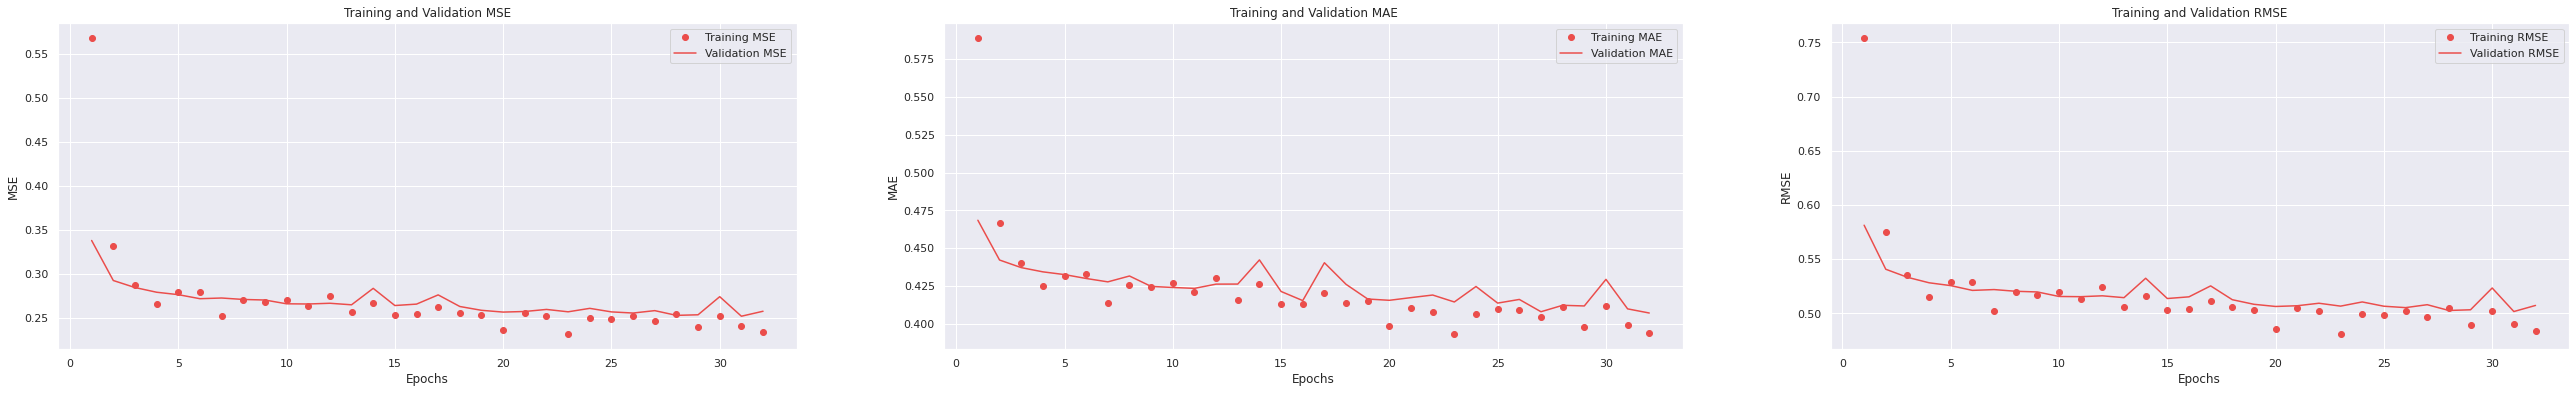

In [80]:
plot_model_hist(history)

In [81]:
train_padd = MyPaddedCorpus(train_emb,train_X_query_max_len,train_X_description_max_len,embbeding_size)
val_padd = MyPaddedCorpus(val_emb,train_X_query_max_len,train_X_description_max_len,embbeding_size)
test_padd = MyPaddedCorpus(test_emb,train_X_query_max_len,train_X_description_max_len,embbeding_size)

In [82]:
train = DataGenerator(train_padd,1)
val = DataGenerator(val_padd,1)
test = DataGenerator(test_padd,1)

In [83]:
train_pred = improved_model.predict(train)
val_pred = improved_model.predict(val)
start_time = time.time()
test_pred = improved_model.predict(test)
runtime = time.time() - start_time


Model test predictions examples -

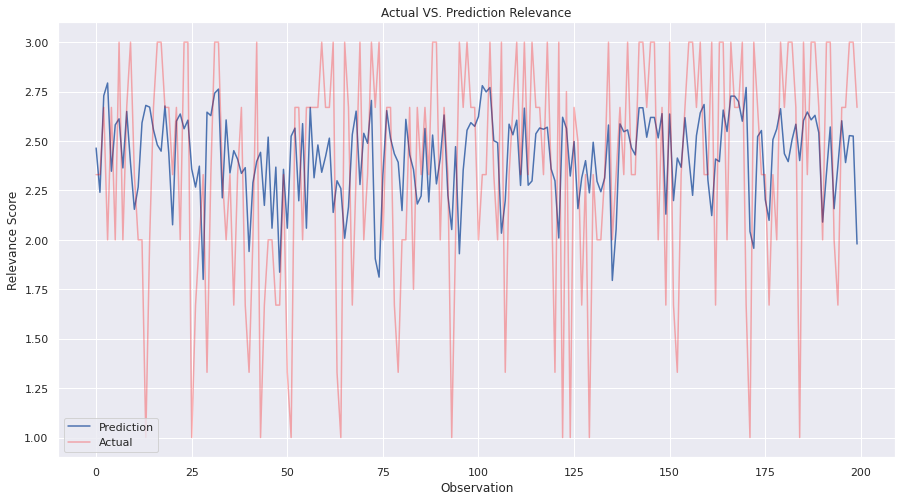

In [84]:
results_df = scores(improved_model,'LSTM Word Level - Complex Siamese Model',train_pred,val_pred,test_pred,train_y,val_y,test_y,runtime,results_df)

Model results comparison -

In [85]:
results_df.set_index('Model Name')

,Runtime,Train RMSE,Val RMSE,Test RMSE,Train MAE,Val MAE,Test MAE
Model Name,,,,,,,
LSTM Character Level - Simple Siamese Model,226.841804,0.514194,0.528296,0.533170,0.419383,0.422929,0.432371
LSTM Character Level - Complex Siamese Model,268.791917,0.520142,0.578006,0.533278,0.426692,0.456363,0.431324
Benchmark RandomForest,0.068968,0.521072,0.526278,0.527402,0.426041,0.430345,0.430705
Benchmark XGB,0.107799,1.230849,1.234210,1.230990,1.125867,1.128628,1.125417
FE & RandomForest,0.044175,0.525604,0.548533,0.534388,0.433839,0.434072,0.436724
FE & KNeighbors,0.180477,0.397274,0.611859,0.649485,0.295012,0.479093,0.512002
LSTM Word Level - Simple Siamese Model,460.64,0.487814,0.511283,0.532626,0.395698,0.415668,0.432954
LSTM Word Level - Complex Siamese Model,542.814,0.474836,0.507395,0.533394,0.380191,0.407297,0.428939


This time the Complex model achived a bit better results. Over all he gets the best numbers so far, even thoguht most results are pretty close.

## Part 4

In this part we will use our best siamese model from part 3 as a feature extractor for an ML model.

We will implement it with Random Forest Regressor and K Neighbors Regressor:

In [86]:
train_padd = MyPaddedCorpus(train_emb,train_X_query_max_len,train_X_description_max_len,embbeding_size)
val_padd = MyPaddedCorpus(val_emb,train_X_query_max_len,train_X_description_max_len,embbeding_size)
test_padd = MyPaddedCorpus(test_emb,train_X_query_max_len,train_X_description_max_len,embbeding_size)

In [87]:
FE_model = improved_model
FE_model.summary()

train = DataGenerator(train_padd,1)
val = DataGenerator(val_padd,1)
test = DataGenerator(test_padd,1)

FE_train = FE_model.predict(train) 
FE_val = FE_model.predict(val) 
FE_test = FE_model.predict(test) 

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 9, 360)]     0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           [(None, 108, 360)]   0                                            
__________________________________________________________________________________________________
lstm_8 (LSTM)                   (None, 128)          250368      input_15[0][0]                   
__________________________________________________________________________________________________
lstm_9 (LSTM)                   (None, 128)          250368      input_16[0][0]                   
___________________________________________________________________________________________

In [88]:
rf_reg = RandomForestRegressor(n_estimators=10, max_depth = 5)
rf_reg.fit(FE_train, train_y)

train_pred = rf_reg.predict(FE_train)
val_pred = rf_reg.predict(FE_val)
start_time = time.time()
test_pred = rf_reg.predict(FE_test)
runtime = time.time() - start_time


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Model test predictions examples -

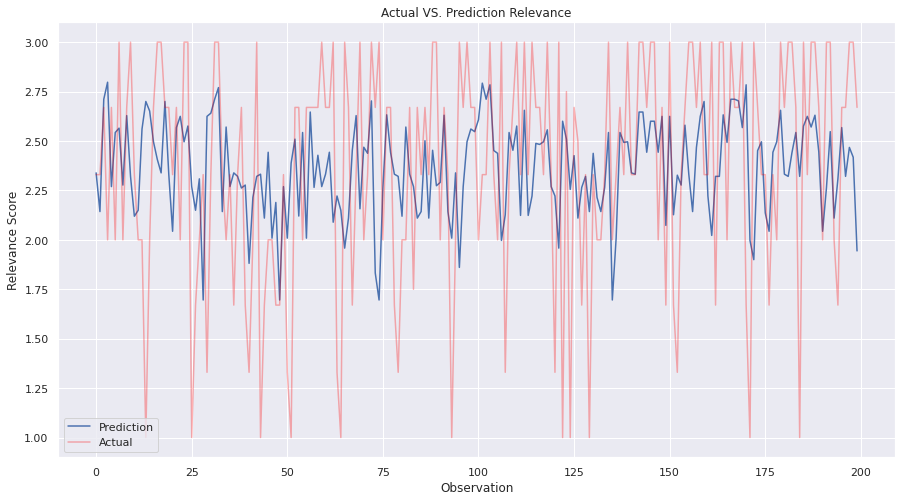

In [89]:
results_df = scores(rf_reg,'Word level FE & RandomForest',train_pred,val_pred,test_pred,train_y,val_y,test_y,runtime,results_df)


In [90]:
results_df.set_index('Model Name')

,Runtime,Train RMSE,Val RMSE,Test RMSE,Train MAE,Val MAE,Test MAE
Model Name,,,,,,,
LSTM Character Level - Simple Siamese Model,226.841804,0.514194,0.528296,0.533170,0.419383,0.422929,0.432371
LSTM Character Level - Complex Siamese Model,268.791917,0.520142,0.578006,0.533278,0.426692,0.456363,0.431324
Benchmark RandomForest,0.068968,0.521072,0.526278,0.527402,0.426041,0.430345,0.430705
Benchmark XGB,0.107799,1.230849,1.234210,1.230990,1.125867,1.128628,1.125417
FE & RandomForest,0.044175,0.525604,0.548533,0.534388,0.433839,0.434072,0.436724
FE & KNeighbors,0.180477,0.397274,0.611859,0.649485,0.295012,0.479093,0.512002
LSTM Word Level - Simple Siamese Model,460.64,0.487814,0.511283,0.532626,0.395698,0.415668,0.432954
LSTM Word Level - Complex Siamese Model,542.814,0.474836,0.507395,0.533394,0.380191,0.407297,0.428939
Word level FE & RandomForest,0.0424869,0.469323,0.504576,0.532869,0.378769,0.40843,0.432063


In [91]:
KNN_reg = KNeighborsRegressor(n_neighbors=2)
KNN_reg.fit(FE_train, train_joined_df2['relevance'])

train_pred = KNN_reg.predict(FE_train)
val_pred = KNN_reg.predict(FE_val)
start_time = time.time()
test_pred = KNN_reg.predict(FE_test)
runtime = time.time() - start_time

Model test predictions examples -

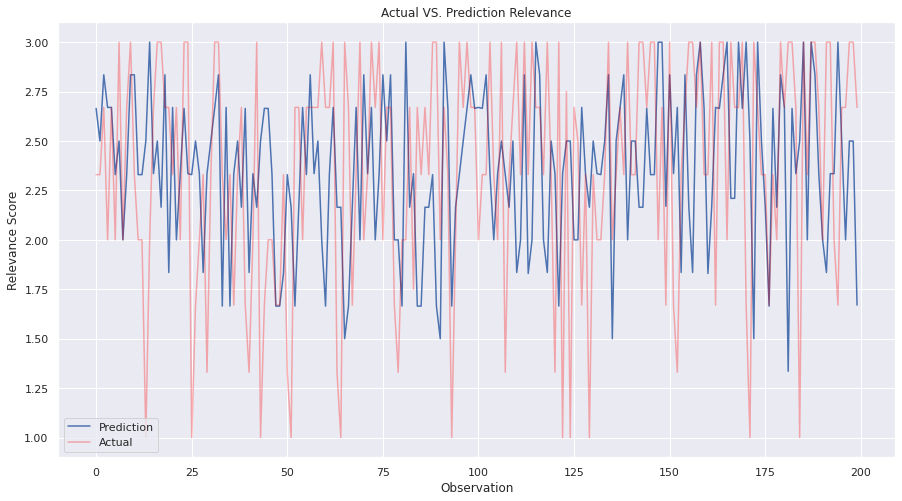

In [92]:
results_df = scores(rf_reg,'Word level FE & KNeighbors',train_pred,val_pred,test_pred,train_y,val_y,test_y,runtime,results_df)

In [93]:
results_df.set_index('Model Name')

,Runtime,Train RMSE,Val RMSE,Test RMSE,Train MAE,Val MAE,Test MAE
Model Name,,,,,,,
LSTM Character Level - Simple Siamese Model,226.841804,0.514194,0.528296,0.533170,0.419383,0.422929,0.432371
LSTM Character Level - Complex Siamese Model,268.791917,0.520142,0.578006,0.533278,0.426692,0.456363,0.431324
Benchmark RandomForest,0.068968,0.521072,0.526278,0.527402,0.426041,0.430345,0.430705
Benchmark XGB,0.107799,1.230849,1.234210,1.230990,1.125867,1.128628,1.125417
FE & RandomForest,0.044175,0.525604,0.548533,0.534388,0.433839,0.434072,0.436724
FE & KNeighbors,0.180477,0.397274,0.611859,0.649485,0.295012,0.479093,0.512002
LSTM Word Level - Simple Siamese Model,460.64,0.487814,0.511283,0.532626,0.395698,0.415668,0.432954
LSTM Word Level - Complex Siamese Model,542.814,0.474836,0.507395,0.533394,0.380191,0.407297,0.428939
Word level FE & RandomForest,0.0424869,0.469323,0.504576,0.532869,0.378769,0.40843,0.432063


Its looks like the feature extractor models resulted over fitting. The train results are much better then validation and test, more significant in the K Neighbors model. 

# Result Comparison

In conclusion, the model that returns the best results is the 'LSTM Word Level - Complex Siamese Model'. we've seen that embedding in words level can return better results than character level & using this model as Feature extractor to ML algorithm may cause over fitting.